# Machine Learning Fundamentals

## Summary

- Terminology and notations
- Gradient descent
- Performance measures

## Terminology and notations

### The elements of a supervised ML system

1. Some **data** under numeric form.
1. A **model** able to produce results from data.
1. A **loss (or cost) function** to quantify the model error (difference between expected and actual results).
1. An **optimization algorithm** to update the model's parameters in order to minimize the loss.

### Terminology and notations: data

- $ m $ is the number of samples and associated results in the dataset.
- $ n $ is the number of features. A **feature** is an attribute (a property) of the data samples.
- $ \mathbf{x}^{(i)} $ is a **sample**, a particular instance of data, vector of $ n $ features: $ \mathbf{x}^{(i)} = \left\{ x^{(i)}_1, x^{(i)}_2, \dotsc, x^{(i)}_n \right\} $.
- $ x^{(i)}_j $ is the value of the $j$th feature for the $i$th data sample.
- $ \mathbf{y}^{(i)} $ is the expected result for a sample, vector of $ K $ values called **labels** (or *targets*): $ \mathbf{y}^{(i)} = \left\{ y^{(i)}_1, y^{(i)}_2, \dotsc, y^{(i)}_K \right\} $.
- $ y^{(i)}_k $ is the value of the $k$th label for the $i$th data sample.

Most ML algorithms except input data to come as a 2-dimensional matrix (*samples, features*)

- First dimension is for the $ m $ samples.
- Second dimension is for the $ n $ features of each sample.

Targets should be formatted using the same first dimension.

$$\mathbf{X} = \begin{pmatrix}
       \ x^{(1)}_1 & x^{(1)}_2 & \cdots & x^{(1)}_n \\
       \ x^{(2)}_1 & x^{(2)}_2 & \cdots & x^{(2)}_n \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ x^{(m)}_1 & x^{(m)}_2 & \cdots & x^{(m)}_n
     \end{pmatrix}\;\;
\mathbf{Y} = \begin{pmatrix}
       \ y^{(1)}_1 & y^{(1)}_2 & \cdots & y^{(1)}_K \\
       \ y^{(2)}_1 & y^{(2)}_2 & \cdots & y^{(2)}_K \\
       \ \vdots & \vdots & \ddots & \vdots \\
       \ y^{(m)}_1 & y^{(m)}_2 & \cdots & y^{(m)}_K
     \end{pmatrix}$$

### Multidimensional data: reshaping

A bitmap image can be represented as a 3D multidimensional array (*height, width, color_channels*).

A video can be represented as a 4D multidimensional array (*frames, height, width, color_channels*).

They have to be **reshaped**, or *flattened* in that case, into a vector before being fed to most ML models.

![Image to vector](images/image2vector.jpeg)

### Example: the MNIST handwritten digits datasets

Dataset of 70,000 handwritten digits, stored as 28x28 grayscale images.

Staple of Machine Learning since 1998.

In [1]:
import platform
print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Python version: 3.7.5


In [77]:
import sklearn
print(f'scikit-learn version: {sklearn.__version__}')
assert sklearn.__version__ >= "0.22" # For plot_confusion_matrix

from sklearn.metrics import log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

scikit-learn version: 0.22.1
TensorFlow version: 2.0.0
Keras version: 2.2.4-tf


In [3]:
# Load the MNIST digits dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(f"Training images: {train_images.shape}. Training labels: {train_labels.shape}")
print(f"Test images: {test_images.shape}. Test labels: {test_labels.shape}")

Training images: (60000, 28, 28). Training labels: (60000,)
Test images: (10000, 28, 28). Test labels: (10000,)


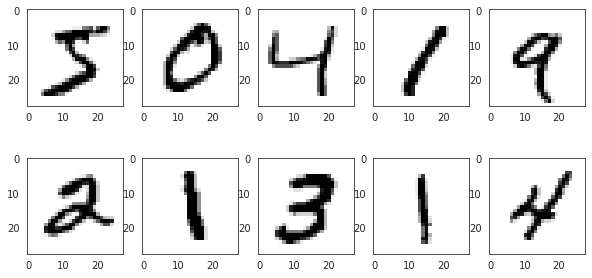

In [4]:
# Plot the first 10 digits
with sns.axes_style('white'):  # Temporary hide Seaborn grid lines
    plt.figure(figsize=(10, 5))
    for i in range(10):
        digit = train_images[i]
        fig = plt.subplot(2, 5, i + 1)
        plt.imshow(digit, cmap=plt.cm.binary)

In [5]:
# Reshape images into a (samples, 28x28) matrix
x_train = train_images.reshape((60000, 28 * 28))
x_test = test_images.reshape((10000, 28 * 28))

# 784=28x28
print(f"x_train: {x_train.shape}")

x_train: (60000, 784)


### Multidimensional data: scaling

Individual pixel values for images and videos are typically integers in the [0:255] range.

Scaling them to obtain floats into the [0:1] ensures is a common practice.

In [6]:
# Rescale pixel values from [0:255] to [0:1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### Terminology and notations: model

- It defines the relationship between features and labels.
- $ \boldsymbol{\theta} $ (or $ \boldsymbol{\omega} $) is the set of its internal **parameters**, vector of $ P $ values: $ \boldsymbol{\theta} = \left\{ \theta_0, \theta_2, \dotsc, \theta_{P-1} \right\} $.
- $h_\theta$ is the model's prediction function, called the *hypothesis function*. This function relies on the model parameters $\boldsymbol{\theta}$ and treats them as constants during prediction computation.
- $ \mathbf{y}'^{(i)} $ is the hypothesis function's output. 

$$ \mathbf{y}'^{(i)} = h_\theta(\mathbf{x}^{(i)}) = \left\{ y'^{(i)}_1, y'^{(i)}_2, \dotsc, y'^{(i)}_K \right\} $$ 

### Example: linear relationship between features and labels

- In this case, $K=1$ and $P=n$.
- The prediction output is a scalar value.

$$y'^{(i)} = \mathcal{h}_\theta(\mathbf{x}^{(i)}) = \theta_0 + \theta_1x^{(i)}_1 + \dotsc + \theta_nx^{(i)}_n$$

### Terminology and notations: loss

- $ \mathcal{L_{\mathbf{X, Y}}(\theta)} $ (or $ \mathcal{J_{\mathbf{X, Y}}(\theta)} $) is the **loss** (or *cost*) **function** that quantifies the difference between expected results (called *ground truth*) and actual results computed by the model.
- During model training, the input dataset $\mathbf{X}$ and the expected results $\mathbf{Y}$ are treated as constants. The loss depends solely on the model parameters $\boldsymbol{\theta}$.
- To simplify notations, the loss function will be written $ \mathcal{L(\boldsymbol{\theta})} $.
- Different loss functions exists. The choice depends on the learning type.

### Loss functions for regression

- *Mean Absolute Error* (aka *l1 or Manhattan norm*):
$$ \mathrm{MAE}(\boldsymbol{\theta}) = \frac{1}{m}\sum_{i=1}^m |\mathcal{h}_\theta(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}| $$
- *Mean Squared Error* (aka *l2 norm*), the default choice:
$$ \mathrm{MSE}(\boldsymbol{\theta}) = \frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})^2 $$
- *Root Mean Squared Error* (aka *Euclidean norm*):
$$ \mathrm{RMSE}(\boldsymbol{\theta}) = \sqrt{\frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})^2} $$

### Loss function for binary classification

- The expected result $ y^{(i)} $ is either 0 or 1.
- The computed result $ y'^{(i)} $ is a probability (float value between 0 and 1).
- A frequently used loss function for binary classification is the *Binary Crossentropy* (aka *Log Loss*): 

$$\mathcal{L}(\boldsymbol{\theta}) = -\frac{1}{m}\sum_{i=1}^m \left[y^{(i)} \log_e(y'^{(i)}) + (1-y^{(i)}) \log_e(1-y'^{(i)})\right]$$

In [7]:
# Define expected results
y_true = [0, 0, 1, 1]

# [.9, .1] means 90% probability that the first sample has label 0: prediction is 0.1
y_pred = [[.9, .1], [.8, .2], [.3, .7], [.01, .99]]
# -(ln(0.9) + ln(0.8) + ln(0.7) + ln(0.99))/4
print(log_loss(y_true, y_pred))

# Perfect prediction
y_pred = [[1, 0], [1, 0], [0, 1], [0, 1]]
print(log_loss(y_true, y_pred))

# Awful prediction
y_pred = [[.1, .9], [.15, .85], [.83, .17], [0.95, .05]]
print(log_loss(y_true, y_pred))

0.1738073366910675
9.992007221626415e-16
2.241848548341448


### Terminology and notations: multiclass classification

* $ \mathbf{y}^{(i)} $ et $ \mathbf{y}'^{(i)} $ are vectors with as many elements as the number of predicted classes $ K $.
* $ \mathbf{y}^{(i)} $ is a **binary vector** of $ K $ values: $ \mathbf{y}^{(i)} = \left\{ y^{(i)}_1, y^{(i)}_2, \dotsc, y^{(i)}_K \right\} $.
* $ y^{(i)}_k $ is equal to 1 if the $i$th sample's class corresponds to $ k $, 0 otherwise.
* $ \mathbf{y}'^{(i)} $ is a **probability vector**.

$$\mathbf{Y} = \begin{pmatrix}
       \ y^{(1)}_1 & \cdots & y^{(1)}_K \\
       \ y^{(2)}_1 & \cdots & y^{(2)}_K \\
       \ \vdots & \ddots & \vdots \\
       \ y^{(m)}_1 & \cdots & y^{(m)}_K
     \end{pmatrix}\;\;
\mathbf{Y}' = \begin{pmatrix}
       \ y'^{(1)}_1 & \cdots & y'^{(1)}_K \\
       \ y'^{(2)}_1 & \cdots & y'^{(2)}_K \\
       \ \vdots & \ddots & \vdots \\
       \ y'^{(m)}_1 & \cdots & y'^{(m)}_K
     \end{pmatrix}$$

### Loss function for multiclass classification

The standard loss function for multiclass classification is *Categorical Crossentropy*:

$$\mathcal{L}(\boldsymbol{\theta}) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K y^{(i)}_k \log_e(y'^{(i)}_k)$$

It is equivalent to _Binary Crossentropy_ when $ K = 2 $

### Model lifecycle

There are two (repeatable) phases:

- **Training**: using training input samples, the model learns to find a relationship between features and labels.
- **Inference**: the trained model is used to make predictions.

### Optimization algorithm

- Used during the training phase.
- For each learning type, several algorithms of various complexity exist.
- Objective: find the set of model parameters $\boldsymbol{\theta_{best}}$ that minimizes the loss.

[![Optimization: linear regression](images/LossSideBySide.png)](https://developers.google.com/machine-learning/crash-course/reducing-loss/an-iterative-approach)

### Model hyperparameters

- Many ML models also have user-defined properties called **hyperparameters**.
- Examples: maximum depth of a decision tree, number oy layers of a neural network...
- Contrary to internal parameters, they are not automatically updated during training.
- The hyperparameters directly affect the model's performance and must be tweaked during the training and tuning steps.

## Gradient descent

### An iterative approach

The model's parameters are iteratively updated until an optimum is reached.

[![Iterative approach](images/GradientDescentDiagram.png)](https://developers.google.com/machine-learning/crash-course/descending-into-ml/training-and-loss)

### The gradient descent algorithm

- Used in several ML models, including neural networks.
- General idea: converging to a loss function's minimum by updating model parameters in small steps, in the **opposite direction** of the loss function **gradient**.

### The notion of gradient

- Expresses the variation of a function *wrt* the variation of its parameters.
- Vector containing partial derivatives of the function *wrt* each of its $ P $ parameters.

$$\nabla_{\theta}\mathcal{L}(\boldsymbol{\theta}) = \begin{pmatrix}
       \ \frac{\partial}{\partial \theta_1} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \frac{\partial}{\partial \theta_2} \mathcal{L}(\boldsymbol{\theta}) \\
       \ \vdots \\
       \ \frac{\partial}{\partial \theta_P} \mathcal{L}(\boldsymbol{\theta})
     \end{pmatrix}$$

### 1D gradient descent (one parameter)

![Gradient Descent](images/gradient_descent_1parameter.png)

### 2D gradient (two parameters)

![Tangent Space](images/tangent_space.png)

### 2D gradient descent

![Gradient Descent](images/gradient_descent_2parameters.gif)

### Gradient descent types

The gradient descent process can be done in several ways:

- _Batch Gradient Descent_
- _Stochastic Gradient Descent_
- _Mini-Batch SGD_

### Batch Gradient Descent

The gradient is computed on the whole dataset before model parameters are updated.

- Advantages: simple and safe (always converges in the right direction).
- Drawback: can become slow and even untractable with a big dataset.

### Stochastic Gradient Descent (SGD)

The gradient is computed on only one radomly chosen sample whole dataset before parameters are updated.

- Advantages:
  - Very fast.
  - Enables learning from each new sample (*online learning*).
- Drawback:
  - Convergence is not guaranteed.
  - No vectorization of computations.

### Mini-Batch SGD

The gradient is computed on a small set of samples, called a *batch*, before parameters are updated.

- Combines the advantages of batch and stochastic GD.
- Default method for many ML libraries.
- The mini-batch size varies between 10 and 1000 samples, depending of the dataset size.

### Updating the model's parameters

$ \eta $ is the update factor for parameters once gradient is computed, called the **_learning rate_**.

It has a direct impact on the "speed" of the gradient descent.

$$ \boldsymbol{\theta_{next}} = \boldsymbol{\theta} - \eta\nabla_{\boldsymbol{\theta}}\mathcal{L}(\boldsymbol{\theta})$$

### Importance of learning rate

![Learning rate](images/learning_rate.png)

[Interactive exercise](https://developers.google.com/machine-learning/crash-course/fitter/graph)

### The local minima problem

![Local minima](images/local_minima.jpg)

![Gradient Descent](images/gd_ng.jpg)

### Example: training a binary classifier using SGD

In [8]:
# Show 10 random labels (integer scalars between 0 and 9)
df_train_labels = pd.DataFrame(train_labels)
df_train_labels.columns = {'digit'}
df_train_labels.head()

,digit
0,5
1,0
2,4
3,1
4,9


In [9]:
# Create binary vectors of expected results
# label is true for all 5s, false for all other digits
y_train_5 = (train_labels == 5)
y_test_5 = (test_labels == 5)

# true, false, false
print(y_train_5[0], y_train_5[1], y_train_5[2])

True False False


In [10]:
# Create a classifier using stochastic gradient descent and log loss
model = SGDClassifier(loss="log")

# Trains the model on data
model.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

## Performance measures

(Heavily inspired by Chapter 3 of [Hands-On Machine Learning](https://github.com/ageron/handson-ml2) by Aurélien Géron)

### Performance metrics for regression

A typical performance metric for regression tasks is RMSE.

$$ \mathrm{RMSE}(\mathbf{X}, h_\theta) = \sqrt{\frac{1}{m}\sum_{i=1}^m (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})^2} $$

MAE (less sensitive to outliers) and MSE can also be used.


### Performance metrics for classification

During inference, the model output (probabilities) are thresholded into discrete values.

Thresholds are problem-dependent.

In [76]:
# Test on first 3 digits
samples = [x_train[0], x_train[1], x_train[2]]

# Print binary predictions (5/not 5)
print(model.predict(samples))

# Print prediction probabilities
model.predict_proba(samples).round(decimals=3)

[ True False False]


array([[0.076, 0.924],
       [1.   , 0.   ],
       [1.   , 0.   ]])

### Accuracy

A simple evaluation metric for classification is **accuracy**.

$$Accuracy = \frac{\text{Number of exact predictions}}{\text{Total number of predictions}} $$

In [65]:
# Define ground truth and prediction vectors
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 1, 2, 2, 0, 1]

# Using scikit-learn to compute accuracy
acc = accuracy_score(y_true, y_pred)

# 4 good predictions, 6 total => accuracy = 2/3
print(f"Accuracy: {acc:.5f}")

Accuracy: 0.66667


In [60]:
# The score() method computes accuracy for SGDClassifier
print(f"SGDClassifier accuracy: {model.score(x_train, y_train_5):.05f}")

# Computing accuracy by hand
train_acc = np.sum([model.predict(x_train) == y_train_5])/len(x_train)
print(f"Manual computation: {train_acc:.05f}")

# Using cross-validation to evaluate accuracy, using 3 folds
cv_acc = cross_val_score(model, x_train, y_train_5, cv=3, scoring="accuracy")
print(f"CV accuracy: {cv_acc}")

SGDClassifier accuracy: 0.97557
Manual computation: 0.97557
CV accuracy: [0.9733  0.9698  0.97065]


### Accuracy shortcomings

When the dataset is *skewed* (some classes are more frequent than others), computing accuracy is not enough to assert the model's performance.

To find out why, let's imagine a dumb binary classifier that always predicts that the digit is not 5.

In [59]:
not5_count = (y_train_5 == False).sum()
print(f"There are {not5_count} digits other than 5 in the training set")

dumb_model_acc = not5_count/len(x_train)
print(f"Dumb classifier accuracy: {dumb_model_acc:.05f}")

There are 54579 digits other than 5 in the training set
Dumb classifier accuracy: 0.90965


### True/False positives and negatives

- **True Positive (TP)**: the model _correctly_ predicts the positive class.
- **False Positive (FP)**: the model _incorrectly_ predicts the positive class.
- **True Negative (TN)**: the model _correctly_ predicts the negative class.
- **False Negative (FN)**: the model _incorrectly_ predicts the negative class.

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

### Confusion matrix

Useful representation of classification results. Row are actual classes, columns are predicted classes.

[![Confusion matrix for 5s](images/confusion_matrix.png)](https://github.com/ageron/handson-ml2)

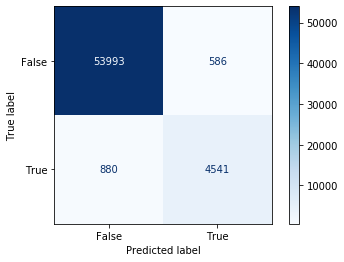

In [82]:
# Plot confusion matrix for our binary classifier
display = plot_confusion_matrix(model, x_train, y_train_5,
                                values_format="d",
                                cmap=plt.cm.Blues)

### Precision and recall

- **Precision**: proportion of positive identifications that were actually correct.
- **Recall**: proportion of actual positives that were identified correctly.

$$Precision = \frac{TP}{TP + FP} = \frac{\text{True Positives}}{\text{Total Predicted Positives}}$$

$$Recall = \frac{TP}{TP + FN} = \frac{\text{True Positives}}{\text{Total Actual Positives}}$$

### Example: a (flawed) tumor classifier

Context: binary classification of tumors (positive means malignant). Dataset of 100 tumors, of which 9 are malignant.

| Negatives | Positives |
|-|-|
| True Negatives: 90 | False Positives: 1 |
| False Negatives: 8 | True Positives: 1|

$$Accuracy = \frac{90+1}{100} = 91\%$$
$$Precision = \frac{1}{1 + 1} = 50\%\;\;\;
Recall = \frac{1}{1 + 8} = 11\%$$

### F1 score

- Weighted average of precision and recall.
- Also known as _balanced F-score_ or _F-measure_.

$$F1 = 2 \times \frac{Precision \times Recall}{Precision + Recall}$$

Good metric in case of class imbalance, when precision and recall are both important.

In [80]:
# Using scikit-learn to compute several metrics about our binary classifier
print(classification_report(y_train_5, model.predict(x_train)))

              precision    recall  f1-score   support

       False       0.98      0.99      0.99     54579
        True       0.89      0.84      0.86      5421

    accuracy                           0.98     60000
   macro avg       0.93      0.91      0.92     60000
weighted avg       0.98      0.98      0.98     60000



### The precision/recall trade-off

- Improving precision typically reduces recall and vice versa ([example](https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall#precision-and-recall:-a-tug-of-war)).
- Precision matters most when the cost of false positives is high (example: spam detection).
- Recall matters most when the cost of false negatives is high (example: tumor detection).

### Example: training a multiclass classifier

In [12]:
# One-hot encoding of expected results
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

print(f"y_train: {y_train.shape}")

# Show random samples of encoded input
df_y_train = pd.DataFrame(y_train)
df_y_train.sample(n=6)

y_train: (60000, 10)


,0,1,2,3,4,5,6,7,8,9
58144,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34656,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26343,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18819,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
34011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10288,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
